In [1]:
import requests
import torch
from PIL import Image
from io import BytesIO
import os
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import statistics


In [2]:
# [ [list with gradients of original pictures], [list with denoised 1], [list with denoised 2]]
# each picture is a list with 3 sublist (for each color)
lst_real_x = torch.load('/content/drive/MyDrive/CMSC673/gradients/real_x_30', map_location=torch.device('cpu'))
lst_real_y = torch.load('/content/drive/MyDrive/CMSC673/gradients/real_y_30', map_location=torch.device('cpu'))
lst_fake_y = torch.load('/content/drive/MyDrive/CMSC673/gradients/fake_dif_y_30', map_location=torch.device('cpu'))
lst_fake_x = torch.load('/content/drive/MyDrive/CMSC673/gradients/fake_dif_x_30', map_location=torch.device('cpu'))

In [3]:
# changing the format to a list of float values representing gradient values
# final result: 3 lists, one with gradients of the original pictures, second with noise1, third with noise2
# each of the lists has 3 sublists for each color, inside each color we have a list of pictures
def gradients(lst):
  gradients_org = []
  gradients_noise1 = []
  gradients_noise2 = []

  for i in range(0,3):
    grad_col_1 = []
    grad_col_2 = []
    grad_col_3 = []

    for sub_list in lst[i]:
      list_1 = list(itertools.chain.from_iterable(sub_list[0]))
      list_2 = list(itertools.chain.from_iterable(sub_list[1]))
      list_3 = list(itertools.chain.from_iterable(sub_list[2]))

      grad_col_1.append([tensor.item() for tensor in list_1])
      grad_col_2.append([tensor.item() for tensor in list_2])
      grad_col_3.append([tensor.item() for tensor in list_3])

      gradients = [grad_col_1, grad_col_2, grad_col_3]

      if i == 0:
        gradients_org = gradients
      elif i == 1:
        gradients_noise1 = gradients
      else:
        gradients_noise2 = gradients

  return gradients_org, gradients_noise1, gradients_noise2

In [4]:
grad_fake_x_org, grad_fake_x_noise1, grad_fake_x_noise2 = gradients(lst_fake_x)
grad_fake_y_org, grad_fake_y_noise1, grad_fake_y_noise2 = gradients(lst_fake_y)
grad_real_x_org, grad_real_x_noise1, grad_real_x_noise2 = gradients(lst_real_x)
grad_real_y_org, grad_real_y_noise1, grad_real_y_noise2 = gradients(lst_real_y)

## Comparing histograms of the picture with the denoised version for real and fake pictures


In [6]:
color = 1
photo = 20

real_1 = grad_real_x_org[color][photo]
real_2 = grad_real_x_noise1[color][photo]
real_3 = grad_real_x_noise2[color][photo]

fake_1 = grad_fake_x_org[color][photo]
fake_2 = grad_fake_x_noise1[color][photo]
fake_3 = grad_fake_x_noise2[color][photo]

In [7]:
# It's hard to see anything when for bigger scale
bins = [float(i) / 100 for i in range(-10, 11)]

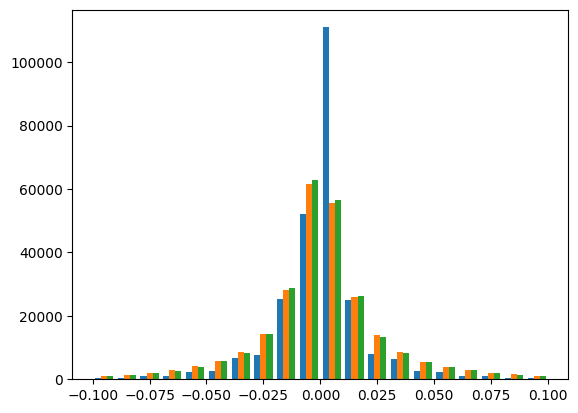

In [8]:
plt.hist([real_1, real_2, real_3], bins=bins)
plt.show()

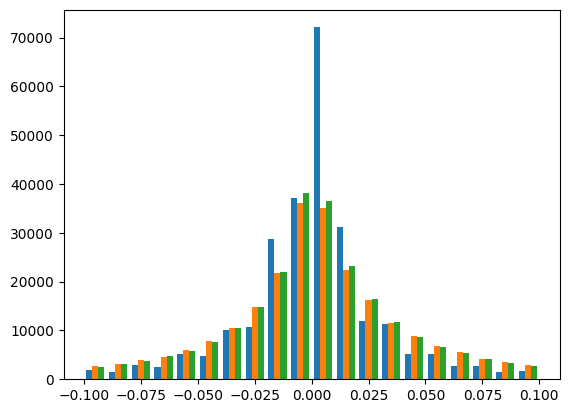

In [9]:
plt.hist([fake_1, fake_2, fake_3], bins=bins)
plt.show()

In [10]:
#  [-1, 1] 0.01
#bins = [float(i) / 100 for i in range(-100, 101)]

#  [-0.5, 0.5] 0.05
bins = [float(i) / 20 for i in range(-10, 11)]

In [11]:
# we create a df which counts how many values is in each bin
def df_count(list1, list2, list3, bins):
  df1 = pd.DataFrame(list1, columns=['original'])
  df1['bin'] = pd.cut(df1['original'], bins=bins)
  df1 = df1.groupby('bin').count()

  df2 = pd.DataFrame(list2, columns=['noise1'])
  df2['bin'] = pd.cut(df2['noise1'], bins=bins)
  df2 = df2.groupby('bin').count()

  df3 = pd.DataFrame(list3, columns=['noise2'])
  df3['bin'] = pd.cut(df3['noise2'], bins=bins)
  df3 = df3.groupby('bin').count()

  df = df1.merge(df2, how='inner', on='bin').merge(df3, how='inner', on='bin')

  return df


In [12]:
def kl_value(df):
  # adding small value to avoid division by 0
  df['original'] = df['original'] + 0.00000000001
  # creating "distribution"
  df['original'] = df['original'] / df['original'].sum()

  df['noise1'] = df['noise1'] + 0.00000000001
  df['noise1'] = df['noise1'] / df['noise1'].sum()

  df['noise2'] = df['noise2'] + 0.00000000001
  df['noise2'] = df['noise2'] / df['noise2'].sum()

  # noise1 and noise2 have very similar distributions
  P = torch.FloatTensor(df['original'])
  Q = torch.FloatTensor(df['noise1'])
  (P * (P / Q).log()).sum()

  return (P * (P / Q).log()).sum()

In [13]:
# here we create a list with KL value for an original picture and a denoised one
# we do it for all colors and treat "each color as a picture". We can set one color in the first loop

KL_div_real_x = []
KL_div_real_y = []
KL_div_fake_x = []
KL_div_fake_y = []


for color in range(0, 3):
  for photo in range(0, len(grad_real_y_org[0])):
    real_1_y = grad_real_y_org[color][photo]
    real_2_y = grad_real_y_noise1[color][photo]
    real_3_y = grad_real_y_noise2[color][photo]

    df_real_y = df_count(real_1_y, real_2_y, real_3_y, bins)

    fake_1_y = grad_fake_y_org[color][photo]
    fake_2_y = grad_fake_y_noise1[color][photo]
    fake_3_y = grad_fake_y_noise2[color][photo]

    df_fake_y = df_count(fake_1_y, fake_2_y, fake_3_y, bins)

    real_1_x = grad_real_x_org[color][photo]
    real_2_x = grad_real_x_noise1[color][photo]
    real_3_x = grad_real_x_noise2[color][photo]

    df_real_x = df_count(real_1_x, real_2_x, real_3_x, bins)

    fake_1_x = grad_fake_x_org[color][photo]
    fake_2_x = grad_fake_x_noise1[color][photo]
    fake_3_x = grad_fake_x_noise2[color][photo]

    df_fake_x = df_count(fake_1_x, fake_2_x, fake_3_x, bins)

    KL_div_real_x.append(kl_value(df_real_x))
    KL_div_real_y.append(kl_value(df_real_y))
    KL_div_fake_x.append(kl_value(df_fake_x))
    KL_div_fake_y.append(kl_value(df_fake_y))


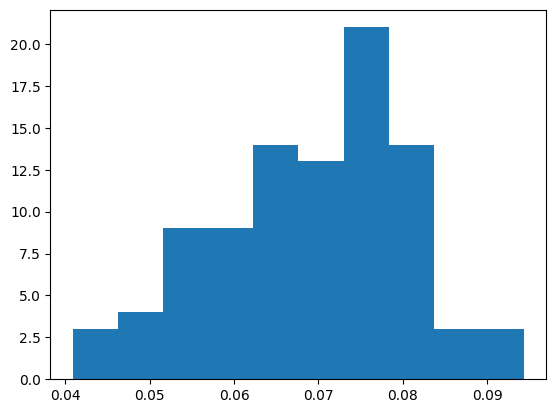

In [14]:
#noise1
plt.hist(KL_div_fake_x)
plt.show()

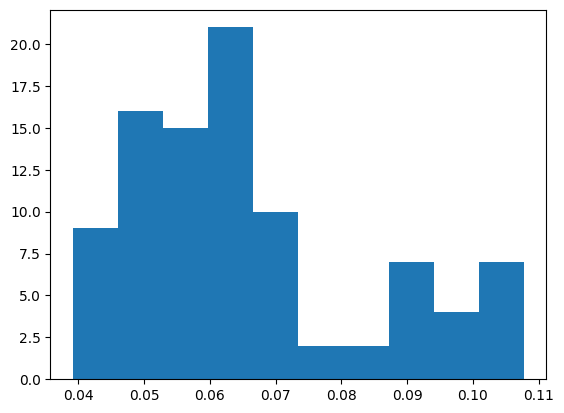

In [15]:
#noise1
plt.hist(KL_div_real_x)
plt.show()

In [16]:
def compare(lst1, lst2):
  print(f'min_1: {min(lst1)}, min_2: {min(lst2)}')
  print(f'max_1: {max(lst1)}, max_2: {max(lst2)}')
  print(f'mean_1: {sum(lst1)/len(lst1)}, mean_2: {sum(lst2)/len(lst2)}')
  print(f'median_1: {statistics.median(lst1)}, median_2: {statistics.median(lst2)}')

In [17]:
compare(KL_div_real_x, KL_div_fake_x)

min_1: 0.03920416161417961, min_2: 0.04092526063323021
max_1: 0.10776069760322571, max_2: 0.09435316920280457
mean_1: 0.06587214767932892, mean_2: 0.06915097683668137
median_1: 0.061510443687438965, median_2: 0.0711568146944046
